In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [6]:
%matplotlib inline

In [10]:
labels : dict = {"Bread" : 0, "Dairy product" : 1, 
                 "Dessert" : 2, 
                 "Egg" : 3, 
                 "Fried food" : 4, 
                 "Meat" : 5, 
                 "Noodles-Pasta" : 6, 
                 "Rice" : 7, i
                 "Seafood" : 8, 
                 "Soup" : 9, 
                 "Vegetable-Fruit" : 10
                }

In [99]:
train_data : list = []
test_data : list = []

In [100]:
for n, i in enumerate(["/kaggle/input/food11-image-dataset/training", "/kaggle/input/food11-image-dataset/evaluation"]):
    for j in os.listdir(i):
        for k in os.listdir(os.path.join(i, j)):
            if not n and cv2.imread(os.path.join(os.path.join(i, j), k)).shape == (512, 512, 3):
                train_data.append([cv2.imread(os.path.join(os.path.join(i, j), k)), labels[j]])
            elif cv2.imread(os.path.join(os.path.join(i, j), k)).shape == (512, 512, 3):
                test_data.append([cv2.imread(os.path.join(os.path.join(i, j), k)), labels[j]])

In [101]:
train_data = np.array(train_data, dtype = "object")
test_data = np.array(test_data, dtype = "object")

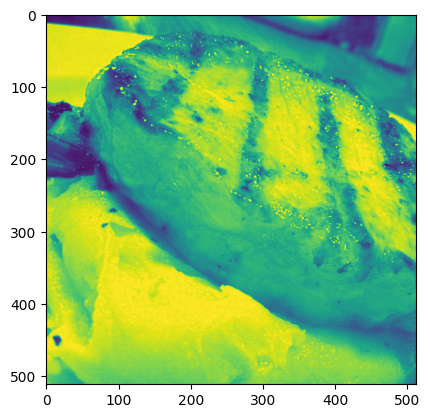

In [105]:
for i in range(3):
    plt.imshow(train_data[4123][0].transpose([2, 0, 1])[i])

In [106]:
list(labels.keys())[train_data[4123][-1]]

'Meat'

In [107]:
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = True)

In [138]:
conv1 = nn.Conv2d(3, 6, 3, 1)
conv2 = nn.Conv2d(6, 12, 3, 1)
conv3 = nn.Conv2d(12, 18, 3, 1)

X = F.relu(conv1(torch.FloatTensor(train_loader.dataset[4123][0].transpose([2, 0, 1]))))
X = F.avg_pool2d(X, 1, 2)
X = F.relu(conv2(X))
X = F.avg_pool2d(X, 2, 2)
X = F.relu(conv3(X))
X = F.avg_pool2d(X, 2, 2)

In [139]:
X.shape

torch.Size([18, 62, 62])

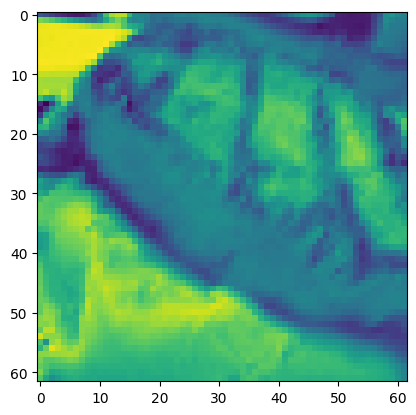

In [140]:
for i in range(18):
    plt.imshow(X.detach().numpy()[i])

In [233]:
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        self.conv3 = nn.Conv2d(12, 18, 3, 1)
        
        self.fc1 = nn.Linear(18 * 62 * 62, 62)
        self.fc2 = nn.Linear(62, 33)
        self.fc3 = nn.Linear(33, 11)
    
    def feedForward(self, X):
        X = F.relu(conv1(torch.FloatTensor(X.transpose([2, 0, 1]))))
        X = F.avg_pool2d(X, 1, 2)
        X = F.relu(conv2(X))
        X = F.avg_pool2d(X, 2, 2)
        X = F.relu(conv3(X))
        X = F.avg_pool2d(X, 2, 2)
        
        X = X.view(-1, 18 * 62 * 62)
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim = 1)

In [234]:
torch.manual_seed(41)

In [235]:
model = CNN()

In [236]:
model

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(12, 18, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=69192, out_features=62, bias=True)
  (fc2): Linear(in_features=62, out_features=33, bias=True)
  (fc3): Linear(in_features=33, out_features=11, bias=True)
)

In [237]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [238]:
import time

start_time = time.time()

# Variables To Track.......
epochs : int = 5
train_losses : list = []
test_losses : list = []
train_correct : list = []
test_correct : list = []

i : int = 1
while i <= epochs:
  train_corr : int = 0
  test_corr : int = 0

  #Training
  for b, (X_train, y_train) in enumerate(train_loader.dataset[:]):
    b += 1
    y_pred = model.feedForward(X_train)
    loss = criterion(y_pred, torch.LongTensor([y_train]))

    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr : int = (predicted == y_train).sum()
    train_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (b + 1) % 100 == 0:
      print(f"Epoch : {i}, Batch : {b + 1}, Loss : {loss.item()}")

  train_losses.append(loss)
  train_correct.append(train_corr)

  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader.dataset[:]):
      y_val = model.feedForward(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      test_corr += (predicted == y_test).sum()

  loss = criterion(y_val, torch.LongTensor([y_test]))
  test_losses.append(loss)
  test_correct.append(test_corr)

  i += 1

current_time = time.time()
print(f"Training took {current_time - start_time} seconds!")

Epoch : 1, Batch : 100, Loss : 0.0
Epoch : 1, Batch : 200, Loss : 0.0
Epoch : 1, Batch : 300, Loss : 0.0
Epoch : 1, Batch : 400, Loss : 0.0
Epoch : 1, Batch : 500, Loss : 0.0
Epoch : 1, Batch : 600, Loss : 0.0
Epoch : 1, Batch : 700, Loss : 0.0
Epoch : 1, Batch : 800, Loss : 0.0
Epoch : 1, Batch : 900, Loss : 0.0
Epoch : 1, Batch : 1000, Loss : 0.0
Epoch : 1, Batch : 1100, Loss : 0.0
Epoch : 1, Batch : 1200, Loss : 0.0
Epoch : 1, Batch : 1300, Loss : 0.0
Epoch : 1, Batch : 1400, Loss : 0.0
Epoch : 1, Batch : 1500, Loss : 0.0
Epoch : 1, Batch : 1600, Loss : 0.0
Epoch : 1, Batch : 1700, Loss : 0.0
Epoch : 1, Batch : 1800, Loss : 0.0
Epoch : 1, Batch : 1900, Loss : 0.0
Epoch : 1, Batch : 2000, Loss : 0.0
Epoch : 1, Batch : 2100, Loss : 0.0
Epoch : 1, Batch : 2200, Loss : 934.5390014648438
Epoch : 1, Batch : 2300, Loss : 0.0
Epoch : 1, Batch : 2400, Loss : 0.0
Epoch : 1, Batch : 2500, Loss : 0.0
Epoch : 1, Batch : 2600, Loss : 0.0
Epoch : 1, Batch : 2700, Loss : 0.0
Epoch : 1, Batch : 2800

In [243]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_loader.dataset[:]:
    y_pred = model.feedForward(X_test)
    predicted = torch.max(y_pred, 1)[1]
    correct += (predicted == y_test).sum()

In [244]:
# Accuracy
print(correct.item(), len(test_data))
print(f"Accuracy : {correct.item() / len(test_data) * 100}%")

238 1978
Accuracy : 12.032355915065724%


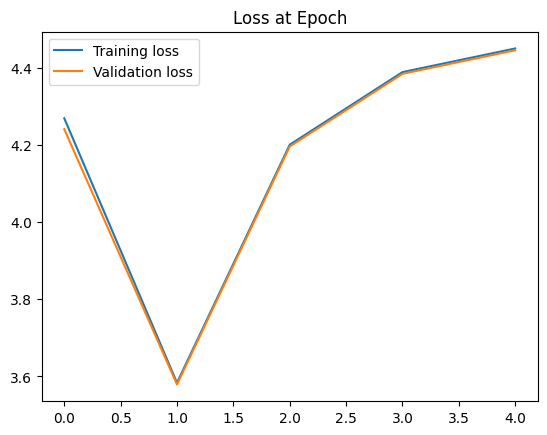

In [245]:
# plotting the results
train_losses = [tl.item() for tl in train_losses]

plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.title("Loss at Epoch")
plt.legend()

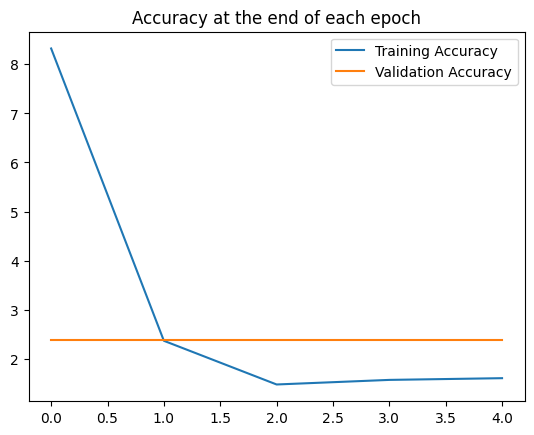

In [246]:
plt.plot([t / 600 for t in train_correct], label = "Training Accuracy")
plt.plot([t / 100 for t in test_correct], label = "Validation Accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()